In [1]:
# Common imports
import numpy as np
import pandas as pd
import os, sys, glob  
import tensorflow as tf
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import tensorflow as tf
from sklearn.model_selection import train_test_split

def reset_graph(seed=42):
    tf.reset_default_graph() 
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def reset_keras_session(seed=42):
    tf.keras.backend.clear_session()
    tf.set_random_seed(seed)
    np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")   # To rid of warnings 

print(tf.__version__)

2.0.0


In [2]:
mit = pd.read_csv('../data/mitbih_train.csv', header=None)
mit_label = mit.iloc[:, -1]
mit = mit.drop(187,axis=1)
zero_arr = np.zeros((mit.shape[0],243))
zero_data = pd.DataFrame(zero_arr, columns=np.arange(187, 430), index=mit.index)
mit_with_zero = pd.concat([mit, zero_data], axis=1)
mit_with_zero['label'] = mit_label
sinus_pvc_data = mit_with_zero.loc[(mit_with_zero['label'] == 0) | (mit_with_zero['label'] == 1), :]
sinus_pvc_arr = sinus_pvc_data.iloc[:,:-1].values
mit_data = sinus_pvc_arr[:, :, np.newaxis]
mit_label = sinus_pvc_data['label']

In [3]:
X_train_mit, X_val_mit, pvc_train_mit, pvc_val_mit = train_test_split(mit_data, mit_label, train_size=0.8, 
                                                                     random_state=42)

In [4]:
X_train_mit.shape, X_val_mit.shape, pvc_train_mit.shape, pvc_val_mit.shape

((59755, 430, 1), (14939, 430, 1), (59755,), (14939,))

In [5]:
y_train_mit = np.zeros((X_train_mit.shape[0], 3))
y_val_mit = np.zeros((X_val_mit.shape[0], 3))

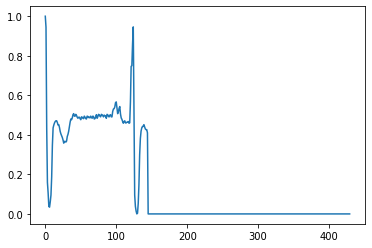

In [6]:
%matplotlib inline
plt.plot(X_train_mit[7])

In [7]:
total_instances = np.load('../data/total_instances.npy', allow_pickle=True)
pvc_label_instances = np.load('../data/total_pvc_label_instances.npy', allow_pickle=True)
label_instances = np.load('../data/total_label_instances.npy', allow_pickle=True)

In [8]:
X_train_dgu, X_val_dgu, y_train_dgu, y_val_dgu, pvc_train_dgu, pvc_val_dgu = train_test_split(total_instances, 
                                                                         label_instances,
                                                                         pvc_label_instances,
                                                                         train_size=0.8, 
                                                                         random_state=42)

In [9]:
X_train_dgu = np.concatenate(X_train_dgu, axis=0)
y_train_dgu = np.concatenate(y_train_dgu, axis=0)
pvc_train_dgu = np.concatenate(pvc_train_dgu, axis=0)

X_val_dgu =  np.concatenate(X_val_dgu, axis=0)
y_val_dgu = np.concatenate(y_val_dgu, axis=0)
pvc_val_dgu = np.concatenate(pvc_val_dgu, axis=0)


print(X_train_dgu.shape, y_train_dgu.shape)
print(X_val_dgu.shape, y_val_dgu.shape)

y_train_dgu = tf.keras.utils.to_categorical(y_train_dgu, 3)
y_val_dgu = tf.keras.utils.to_categorical(y_val_dgu, 3)

(818, 430, 1) (818,)
(207, 430, 1) (207,)


In [10]:
X_train_dgu.shape, X_val_dgu.shape, y_train_dgu.shape, y_val_dgu.shape

((818, 430, 1), (207, 430, 1), (818, 3), (207, 3))

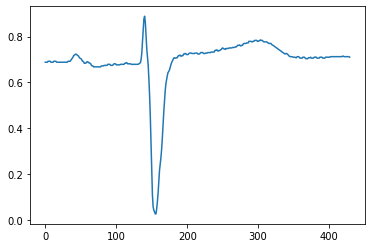

In [11]:
plt.plot(X_train_dgu[19])

# CBAM Attention change 1D->2D

In [12]:
X_train_mit.shape, X_val_mit.shape, X_train_dgu.shape, X_val_dgu.shape

((59755, 430, 1), (14939, 430, 1), (818, 430, 1), (207, 430, 1))

In [13]:
X_train_mit[:,:,:,np.newaxis].shape

(59755, 430, 1, 1)

In [14]:
X_train_mit_4d = X_train_mit[:,:,:,np.newaxis]
X_val_mit_4d = X_val_mit[:, :, :, np.newaxis]
X_train_dgu_4d = X_train_dgu[:, :, :, np.newaxis]
X_val_dgu_4d = X_val_dgu[:, :, :, np.newaxis]

In [15]:
X_train_mit_4d.shape, X_val_mit_4d.shape, X_train_dgu_4d.shape, X_val_dgu_4d.shape

((59755, 430, 1, 1), (14939, 430, 1, 1), (818, 430, 1, 1), (207, 430, 1, 1))

In [22]:
import tensorflow.keras.backend as K 
from tensorflow.keras.layers import *
from tensorflow.keras import models
from sklearn.metrics import confusion_matrix, classification_report

backend = K

def attach_attention_module(net, attention_module):
    if attention_module == 'se_block': # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block': # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))
    
    return net

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature._keras_shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool._keras_shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool._keras_shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature._keras_shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool._keras_shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool._keras_shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat._keras_shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature._keras_shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

def conv_block(x, growth_rate, name):
    """A building block for a dense block.
    # Arguments
        x: input tensor.
        growth_rate: float, growth rate at dense layers.
        name: string, block label.
    # Returns
        Output tensor for the block.
    """
    bn_axis = 3 if K.image_data_format() == "channels_last" else 1
    x1 = BatchNormalization(axis=bn_axis,
                                   epsilon=1.001e-5,
                                   name=name + '_0_bn')(x)
    x1 = Activation('relu', name=name + '_0_relu')(x1)
    x1 = Conv2D(4 * growth_rate, 1,
                       use_bias=False,
                       name=name + '_1_conv')(x1)
    x1 = BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                   name=name + '_1_bn')(x1)
    x1 = Activation('relu', name=name + '_1_relu')(x1)
    x1 = Conv2D(growth_rate, 3,
                       padding='same',
                       use_bias=False,
                       name=name + '_2_conv')(x1)
    x = Concatenate(axis=3, name=name + '_concat')([x, x1])
    return x

def dense_block(x, blocks, name):
    """A dense block.
    # Arguments
        x: input tensor.
        blocks: integer, the number of building blocks.
        name: string, block label.
    # Returns
        output tensor for the block.
    """
    for i in range(blocks):
        x = conv_block(x, 32, name=name + '_block' + str(i + 1))

    x = attach_attention_module(x, 'cbam_block')
    return x

In [23]:
#blocks = [6, 12, 24, 16]

input_signal = Input(shape=(X_train_mit_4d.shape[1], X_train_mit_4d.shape[2], X_train_mit_4d.shape[3]))
x = dense_block(input_signal, 4, name='conv1')


fc1 = Dense(16, activation='relu')(x)
fc1_drop = Dropout(0.5)(fc1)

fc2 = Dense(32, activation='relu')(fc1_drop)
fc2_drop = Dropout(0.5)(fc2)

shape_fc2_drop = fc2_drop.get_shape().as_list()
reshaped = Reshape((shape_fc2_drop[1], shape_fc2_drop[3]))(fc2_drop)

bgru = Bidirectional(layers.GRU(units=64))(reshaped)
#flatten = Flatten()(reshaped) original

fc3 = Dense(128, activation='relu')(bgru)
fc3_drop = Dropout(0.5)(fc3)
#pvc_dense2 = layers.Dense(32, activation='relu')(pvc_dense1)
pvc_out = Dense(1, activation='sigmoid', name='pvc_out')(fc3_drop)

#class_dense1 = layers.Dense(32, activation='relu')(fc3_drop)
#class_dense2 = layers.Dense(32, activation='relu')(class_dense1)
class_out = Dense(3, activation='softmax', name='class_out')(fc3_drop)

model  = models.Model(inputs=input_signal, outputs=[pvc_out, class_out])
model.summary()

AttributeError: 'Tensor' object has no attribute '_keras_shape'

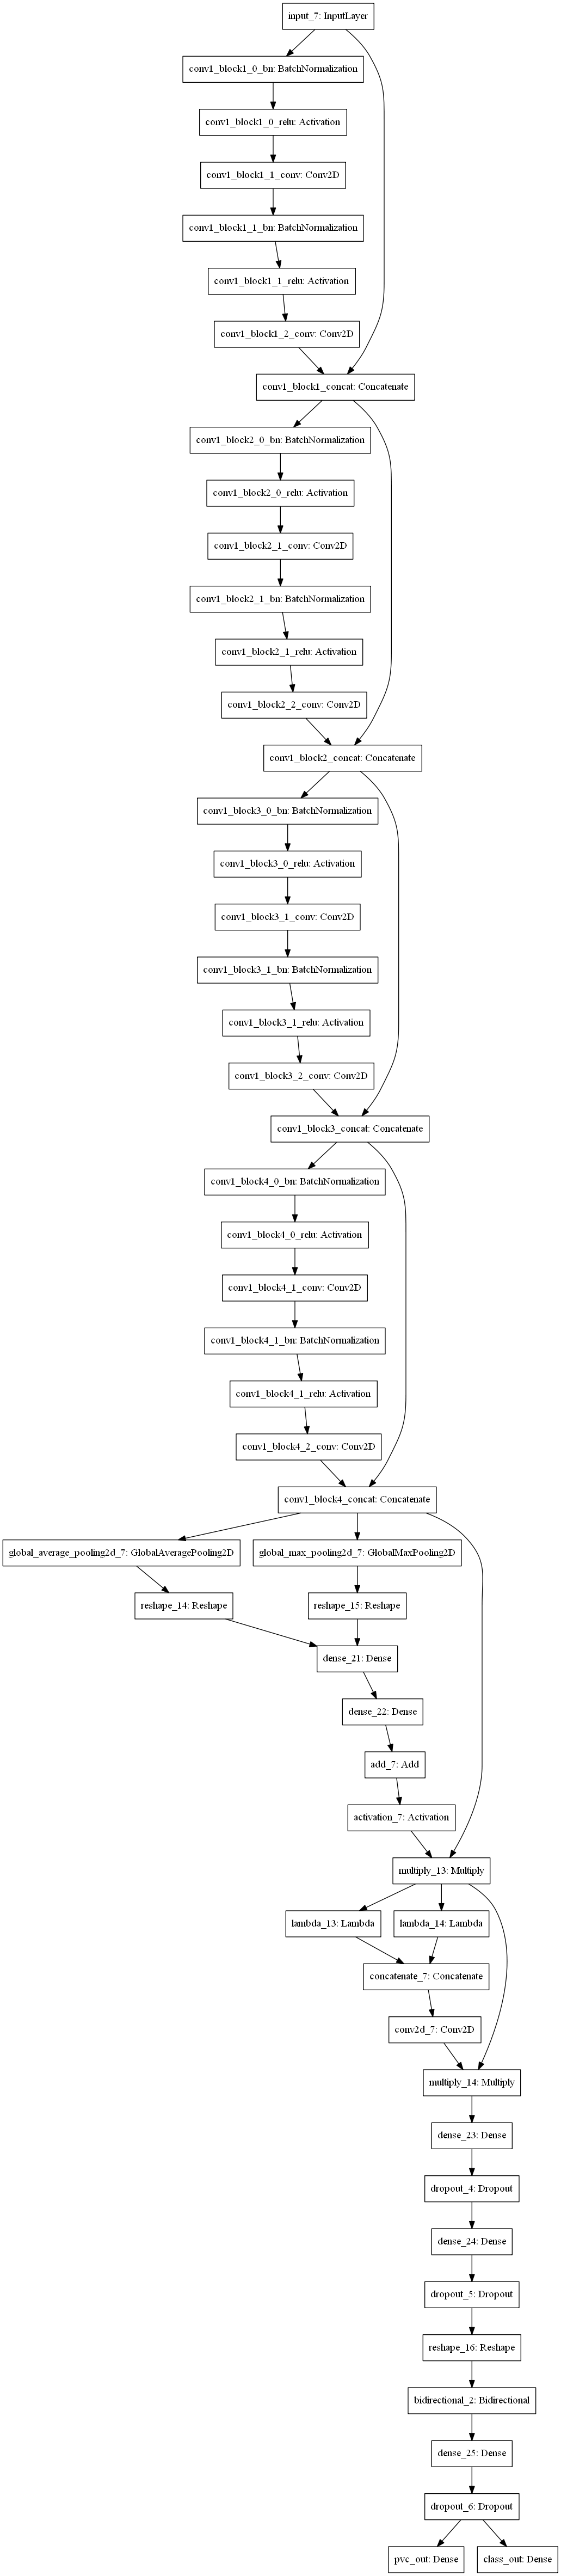

In [53]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,to_file='model_attention_2d.png', show_shapes=False, show_layer_names=True, rankdir='TB' )
Image(retina=True, filename='model_attention_2d.png')

In [54]:
model.layers

In [55]:
for i in range(len(model.layers)) :
    print(model.layers[i])
    print(model.layers[i].trainable)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [56]:
model.layers[0].trainable = True

In [57]:
model.layers[-1].trainable = False

In [59]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

model.compile(optimizer='adam', loss={'pvc_out': 'binary_crossentropy', 'class_out': 'categorical_crossentropy'},
             metrics={'pvc_out': 'acc', 'class_out': 'acc'})

callbacks_list = [EarlyStopping(monitor='val_loss', patience=20),
                  ModelCheckpoint(filepath=model_path, 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=50)]

history = model.fit(X_train_mit_4d, [pvc_train_mit, y_train_mit],
                    epochs=100, batch_size=64, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_mit_4d, [pvc_val_mit,y_val_mit]),
                    shuffle=True)

Train on 59755 samples, validate on 14939 samples
Epoch 1/100
59755/59755 [==============================] - 734s 12ms/step - loss: 0.1061 - pvc_out_loss: 0.1061 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9746 - class_out_acc: 0.1170 - val_loss: 0.0874 - val_pvc_out_loss: 0.0873 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9820 - val_class_out_acc: 0.0096
Epoch 2/100
59755/59755 [==============================] - 733s 12ms/step - loss: 0.0916 - pvc_out_loss: 0.0916 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9795 - class_out_acc: 0.1323 - val_loss: 0.0758 - val_pvc_out_loss: 0.0757 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9831 - val_class_out_acc: 0.0142
Epoch 3/100
59755/59755 [==============================] - 730s 12ms/step - loss: 0.0930 - pvc_out_loss: 0.0931 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9781 - class_out_acc: 0.1112 - val_loss: 0.0714 - val_pvc_out_loss: 0.0713 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9831 - val_class_out_ac

59755/59755 [==============================] - 729s 12ms/step - loss: 0.0323 - pvc_out_loss: 0.0323 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9907 - class_out_acc: 0.1085 - val_loss: 0.0358 - val_pvc_out_loss: 0.0358 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9890 - val_class_out_acc: 0.0308
Epoch 52/100
59755/59755 [==============================] - 728s 12ms/step - loss: 0.0319 - pvc_out_loss: 0.0319 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9905 - class_out_acc: 0.1091 - val_loss: 0.0361 - val_pvc_out_loss: 0.0363 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9892 - val_class_out_acc: 0.0426
Epoch 53/100
59755/59755 [==============================] - 729s 12ms/step - loss: 0.0333 - pvc_out_loss: 0.0333 - class_out_loss: 0.0000e+00 - pvc_out_acc: 0.9904 - class_out_acc: 0.1172 - val_loss: 0.0408 - val_pvc_out_loss: 0.0408 - val_class_out_loss: 0.0000e+00 - val_pvc_out_acc: 0.9881 - val_class_out_acc: 0.0260
Epoch 54/100
59755/59755 [========================

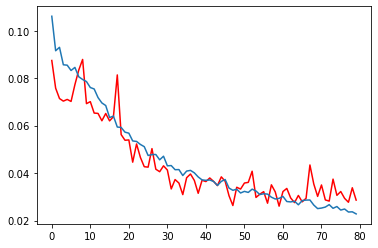

In [60]:
plt.plot(history.history['val_loss'], color='red')
plt.plot(history.history['loss'])

In [18]:
from keras.models import load_model

model  = load_model('./model/60-0.0261.hdf5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [19]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 430, 1, 1)    0                                            
__________________________________________________________________________________________________
conv1_block1_0_bn (BatchNormali (None, 430, 1, 1)    4           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_block1_0_relu (Activation (None, 430, 1, 1)    0           conv1_block1_0_bn[0][0]          
__________________________________________________________________________________________________
conv1_block1_1_conv (Conv2D)    (None, 430, 1, 128)  128         conv1_block1_0_relu[0][0]        
____________________________________________________________________________________________

In [28]:
for i in range(len(model.layers)) :
    print(model.layers[i])
    print(model.layers[i].trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [29]:
model.layers[8:-24]

In [32]:
model.layers[0].trainable = True
model.layers[-1].trainable = True
trainable_false = model.layers[1:-24]

for i in range(len(trainable_false)) :
    trainable_false[i].trainable=False

In [48]:
#final experiments
for i in range(len(model.layers)) :
    model.layers[i].trainable = False
for i in range(-1, -6, -1) :
    model.layers[i].trainable = True

In [49]:
for i in range(len(model.layers)) :
    print(model.layers[i])
    print(model.layers[i].trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [23]:
from keras.callbacks import *

In [53]:
model.compile(optimizer='adam', loss={'pvc_out': 'binary_crossentropy', 'class_out': 'categorical_crossentropy'},
             metrics={'pvc_out': 'acc', 'class_out': 'acc'})

callbacks_list = [EarlyStopping(monitor='val_loss', patience=50), #50
                  ModelCheckpoint(filepath='cbam_attention.h5', 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=80)] #80

history = model.fit(X_train_dgu_4d, [pvc_train_dgu, y_train_dgu],
                    epochs=150, batch_size=128,  #500 batch 128
                    callbacks=callbacks_list,
                    validation_data=(X_val_dgu_4d, [pvc_val_dgu,y_val_dgu]),
                    shuffle=True)

Train on 818 samples, validate on 207 samples
Epoch 1/150
818/818 [==============================] - 7s 9ms/step - loss: 1.6588 - pvc_out_loss: 0.6517 - class_out_loss: 0.9821 - pvc_out_acc: 0.6736 - class_out_acc: 0.6015 - val_loss: 1.6986 - val_pvc_out_loss: 0.6675 - val_class_out_loss: 1.0273 - val_pvc_out_acc: 0.8068 - val_class_out_acc: 0.8068
Epoch 2/150
818/818 [==============================] - 5s 6ms/step - loss: 1.0248 - pvc_out_loss: 0.4696 - class_out_loss: 0.5654 - pvc_out_acc: 0.8325 - class_out_acc: 0.8350 - val_loss: 1.5465 - val_pvc_out_loss: 0.6240 - val_class_out_loss: 0.9128 - val_pvc_out_acc: 0.8068 - val_class_out_acc: 0.8068
Epoch 3/150
818/818 [==============================] - 5s 6ms/step - loss: 0.9751 - pvc_out_loss: 0.4621 - class_out_loss: 0.5358 - pvc_out_acc: 0.8337 - class_out_acc: 0.8337 - val_loss: 1.5332 - val_pvc_out_loss: 0.6225 - val_class_out_loss: 0.9018 - val_pvc_out_acc: 0.8068 - val_class_out_acc: 0.8068
Epoch 4/150
818/818 [==================

KeyboardInterrupt: 

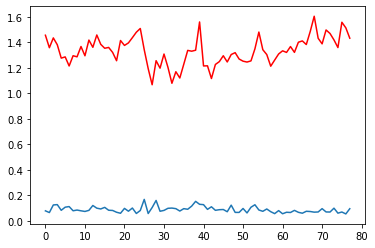

In [51]:
plt.plot(history.history['val_loss'], color='red')
plt.plot(history.history['loss'])

In [46]:
model.evaluate(X_val_dgu_4d, [pvc_val_dgu, y_val_dgu])

207/207 [==============================] - 2s 9ms/step


[1.187842682075961,
 0.5574625730514526,
 0.5940772891044617,
 0.695652186870575,
 0.7198067903518677]

In [47]:
model.metrics_names

['loss', 'pvc_out_loss', 'class_out_loss', 'pvc_out_acc', 'class_out_acc']

In [48]:
pred = model.predict(X_val_dgu_4d)

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pvc_val_dgu, np.hstack(pred[0]>=0.5))
cm2 = confusion_matrix(np.argmax(y_val_dgu, axis=1), np.argmax(pred[1], axis=1))

In [50]:
cm

array([[133,  34],
       [ 29,  11]], dtype=int64)

In [51]:
cm2

array([[146,  21,   0],
       [ 35,   3,   0],
       [  2,   0,   0]], dtype=int64)